# Import packages

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import pyLDAvis.gensim_models as gensimvis
import spacy
import re
import nltk
import gensim
import pyLDAvis
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora
from gensim.models import CoherenceModel, LdaModel
from sklearn.datasets import fetch_20newsgroups
from wordcloud import WordCloud
nlp = spacy.load('en_core_web_md')
nltk.download('stopwords')
nltk.download('punkt')

# Import Data

In [2]:
def twenty_newsgroup_to_csv():
    newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
    df = pd.DataFrame([newsgroups_train.data, newsgroups_train.target.tolist()]).T
    df.columns = ['text', 'target']
    return df.head(5)
twenty_newsgroup_to_csv()

,text,target
0,I was wondering if anyone out there could enli...,7
1,A fair number of brave souls who upgraded thei...,4
2,"well folks, my mac plus finally gave up the gh...",4
3,\nDo you have Weitek's address/phone number? ...,1
4,"From article <C5owCB.n3p@world.std.com>, by to...",14


In [3]:
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
documents = newsgroups_train.data

In [4]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [5]:
# Finding frequency of each category
targets, frequency = np.unique(newsgroups_train.target, return_counts=True)
targets, frequency 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 array([480, 584, 591, 590, 578, 593, 585, 594, 598, 597, 600, 595, 591,
        594, 593, 599, 546, 564, 465, 377]))

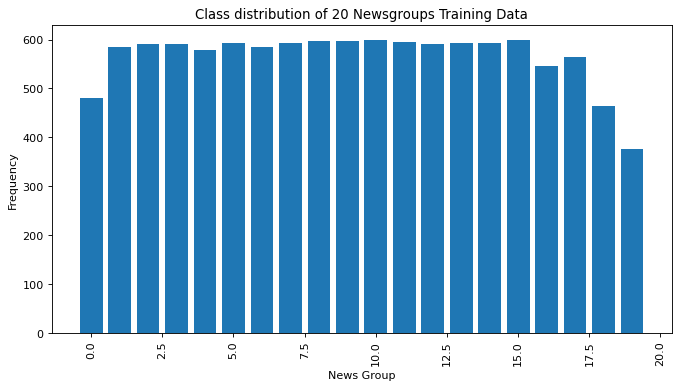

In [6]:
# Data class distribution
fig=plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(targets,frequency)
plt.xticks(rotation=90)
plt.title('Class distribution of 20 Newsgroups Training Data')
plt.xlabel('News Group')
plt.ylabel('Frequency')
plt.show()

# Data preparation

In [7]:
# Define custom stopwords
custom_stopwords = [
    "I", "a", "don't", "madame", "monsieur", "can", "then", "be", "this",
    "these", "this", "this", "like", "thus", "if", "and", "the", "the", "the",
    "two", "three", "also", "all", "all", "more", "it", "according", "fact",
    "after", "again", "THE", "OF", "US", "The", "AND", "TO", "OR", "IS", "His", "He", "ra", 
    "Him", "And", "You", "It", "If", "The", "In", "us", "It", "For", "The", 
    "In", "They", "We", "also"
]

# Combine NLTK's English stopwords with custom stopwords
stop_words = set(stopwords.words('english')).union(custom_stopwords)

def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters (keeping only letters and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove non-alphabetic tokens and single characters
    tokens = [word for word in tokens if word.isalpha() and len(word) > 1]
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

processed_docs = [preprocess(doc) for doc in documents]

# Convert processed_docs to a DataFrame
df_processed = pd.DataFrame({'Original Text': documents, 'Processed Tokens': processed_docs})

# Display the processed data
print(df_processed)


                                           Original Text  \
0      I was wondering if anyone out there could enli...   
1      A fair number of brave souls who upgraded thei...   
2      well folks, my mac plus finally gave up the gh...   
3      \nDo you have Weitek's address/phone number?  ...   
4      From article <C5owCB.n3p@world.std.com>, by to...   
...                                                  ...   
11309  DN> From: nyeda@cnsvax.uwec.edu (David Nye)\nD...   
11310  I have a (very old) Mac 512k and a Mac Plus, b...   
11311  I just installed a DX2-66 CPU in a clone mothe...   
11312  \nWouldn't this require a hyper-sphere.  In 3-...   
11313  Stolen from Pasadena between 4:30 and 6:30 pm ...   

                                        Processed Tokens  
0      [wondering, anyone, could, enlighten, car, saw...  
1      [fair, number, brave, souls, upgraded, si, clo...  
2      [well, folks, mac, plus, finally, gave, ghost,...  
3      [weiteks, addressphone, number, id, 

In [8]:
## Lemmatization: keep only the root forms
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

df_processed["text_word_token0"] = lemmatization(df_processed["Processed Tokens"], allowed_postags=['NOUN', 'ADJ'])

In [9]:
documents_1 = df_processed['text_word_token0'].tolist()
def filter_words(doc):
    return [word for word in doc if len(word) > 2] 

# Apply filtering to each sublist in Document_1
filtered_document = [filter_words(doc) for doc in documents_1]

In [10]:
## Create the dictionary and corpus
id2word = corpora.Dictionary(filtered_document)
corpus = [id2word.doc2bow(doc) for doc in filtered_document]

In [11]:
# Make sure all tokenized items are lists
df_processed = df_processed[df_processed["text_word_token0"].map(type) == list]
df_processed.reset_index(drop=True, inplace=True)

print("After cleaning and excluding short articles, the dataframe now has:", len(df_processed), "articles")

After cleaning and excluding short articles, the dataframe now has: 11314 articles


In [12]:
# Train the LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=20, random_state=100, update_every=1, chunksize=100, passes=10,
                     iterations=100, alpha='auto')

In [13]:
# Calculate Coherence and perplexity

## Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=filtered_document, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

## Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))


Coherence Score:  0.39380800467463006

Perplexity:  -15.797726554721276


# Visualize data Results

In [14]:
# Inspect topics
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.079*"discussion" + 0.040*"job" + 0.040*"head" + 0.038*"night"')
(1, '0.033*"people" + 0.027*"good" + 0.027*"time" + 0.022*"year"')
(2, '0.068*"information" + 0.063*"number" + 0.054*"source" + 0.042*"message"')
(3, '0.083*"space" + 0.042*"mail" + 0.035*"science" + 0.033*"research"')
(4, '0.125*"section" + 0.111*"code" + 0.084*"function" + 0.055*"love"')
(5, '0.172*"argument" + 0.109*"season" + 0.058*"factor" + 0.046*"aware"')
(6, '0.075*"light" + 0.068*"black" + 0.064*"easy" + 0.061*"white"')
(7, '0.149*"key" + 0.097*"chip" + 0.041*"user" + 0.039*"master"')
(8, '0.066*"problem" + 0.030*"sure" + 0.030*"book" + 0.027*"law"')
(9, '0.076*"man" + 0.063*"child" + 0.057*"faith" + 0.044*"word"')
(10, '0.039*"death" + 0.038*"village" + 0.036*"soldier" + 0.031*"military"')
(11, '0.071*"group" + 0.049*"true" + 0.044*"idea" + 0.040*"other"')
(12, '0.125*"system" + 0.080*"drive" + 0.049*"available" + 0.041*"computer"')
(13, '0.072*"program" + 0.070*"thank" + 0.064*"file" + 0.048*"window"')
(1

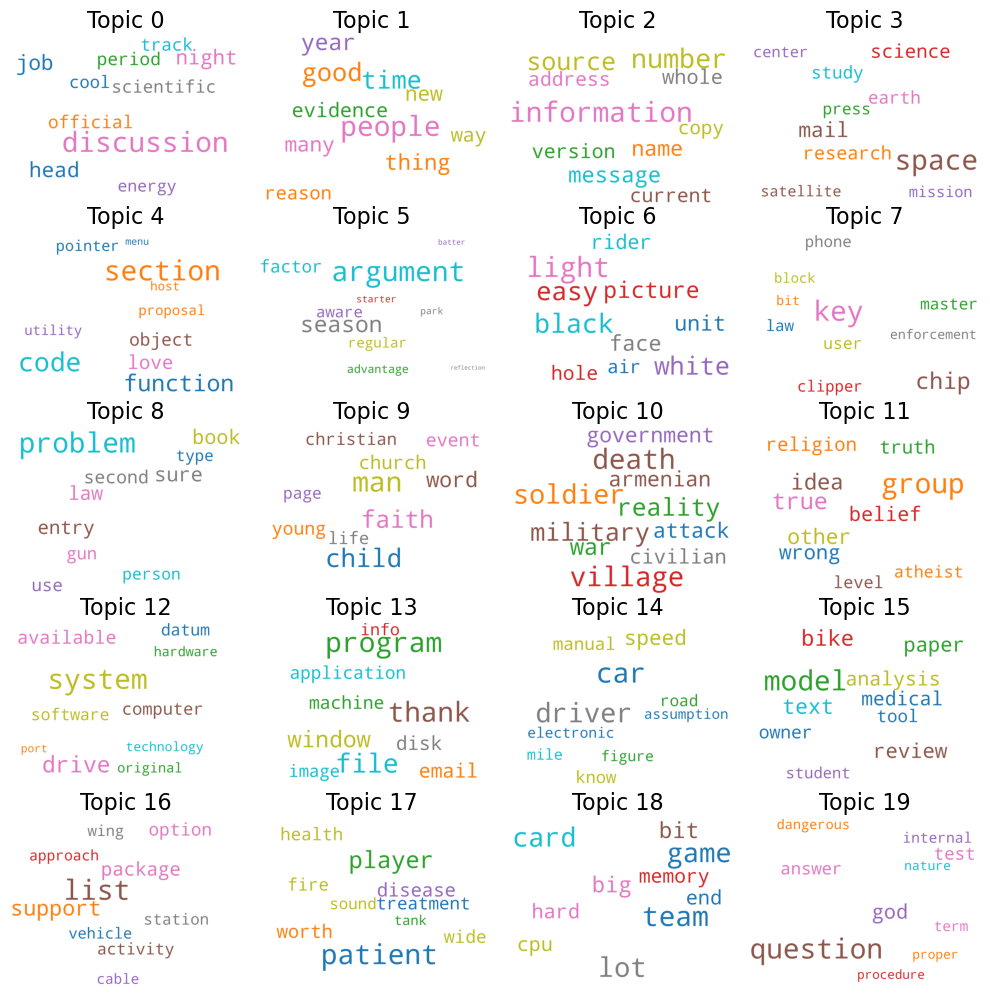

In [15]:
# Define colors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]

# Define WordCloud parameters
cloud = WordCloud(stopwords=stopwords.words('english'),
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  prefer_horizontal=1.0)

# Get topics
topics = lda_model.show_topics(num_topics=20, formatted=False)

# Create a grid for word clouds
fig, axes = plt.subplots(5, 4, figsize=(10, 10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    if i < len(topics):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [16]:
## Visualize the topics using pyLDAvis
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
pyLDAvis.display(vis)